<a href="https://colab.research.google.com/github/Mattizza/FL-project/blob/jack/testTask1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount = True)

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/GitHub/FL-project

/content/drive/MyDrive/GitHub/FL-project


In [2]:
!git init

Initialized empty Git repository in /content/.git/


In [4]:
!git remote add origin https://github.com/Mattizza/FL-project

In [5]:
!git clone https://github.com/Mattizza/FL-project

Cloning into 'FL-project'...
remote: Enumerating objects: 1775, done.
remote: Counting objects: 100% (87/87), done.
remote: Compressing objects: 100% (72/72), done.
remote: Total 1775 (delta 19), reused 75 (delta 12), pack-reused 1688
Receiving objects: 100% (1775/1775), 508.70 MiB | 45.95 MiB/s, done.
Resolving deltas: 100% (21/21), done.
Updating files: 100% (1723/1723), done.


In [1]:
%cd FL-project

[Errno 2] No such file or directory: 'FL-project'
/content


In [2]:
from main import *
import argparse
from centralized import Centralized
from client import *
from torch import optim, nn
from torch.optim import lr_scheduler

In [7]:
class Args():
  def __init__(self, dataset, model, bs, hnm, num_epochs):
    self.dataset = dataset
    self.model = model 
    self.bs = bs
    self.hnm = hnm
    self.num_epochs = num_epochs
    # self.rate_decay = rate_decay
    # self.optimizer = optimizer

args = Args('iddaCB', model = 'deeplabv3_mobilenetv2', bs = 8, hnm = False, 
            num_epochs = 10)

In [8]:
trainAloneDataset, testAloneDatasets = get_datasets(args)
ds = trainAloneDataset[0]

In [9]:
#istanziamo il modello 
model = model_init(args)

In [ ]:
# prova = getattr(optim,'SGD')
# optimizer = prova(self.model.classifier.parameters(), lr = 0.01)

In [ ]:
centralized = Centralized(args,ds,model)
state_dict = torch.load('modelliSalvati/checkpoint.pth')
model.classifier.load_state_dict(state_dict)

opt = "SGD"
params = {'optimizer': {'name': opt,
                        "settings": {"lr": 0.01}},
          'scheduler': {'name': "ExponentialLR",
                        "settings": {"gamma": 0.1
                                     }
centralized.set_opt(params)

centralized.train()

In [11]:
from utils.stream_metrics import StreamSegMetrics
metric = StreamSegMetrics(16, 'centralizzato')
centralized.test(metric)

In [12]:
metric.get_results()['Mean IoU']

0.32416228282139087

In [13]:
from torch.utils.data import DataLoader
train_loader = DataLoader(ds, batch_size = 2, shuffle = False, drop_last = True)

In [14]:
centralized.model.eval()
with torch.no_grad():
  for i, (images, labels) in enumerate(train_loader):
    images = images.cuda() 
    labels = labels.cuda()
    outputs = centralized.model(images)['out']
    break

In [15]:
outputs = centralized.model(images[0].view(1, 3, 512, 928))['out']

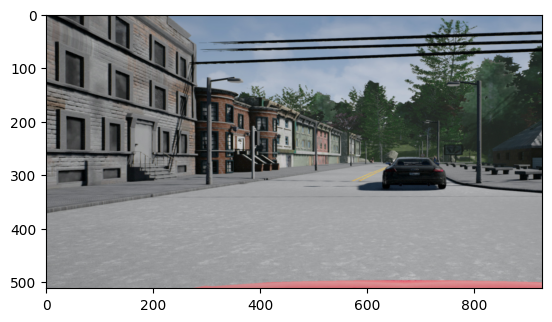

In [16]:
import matplotlib.pyplot as plt
def unNormalize(tensorImage, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
        for t, m, s in zip(tensorImage, mean, std):
            t.mul_(s).add_(m)
        return tensorImage
plt.imshow(unNormalize(images[0].cpu()).permute(1,2,0))

In [17]:
singoloOutputLogits = outputs[0]
prediction = singoloOutputLogits.argmax(0)

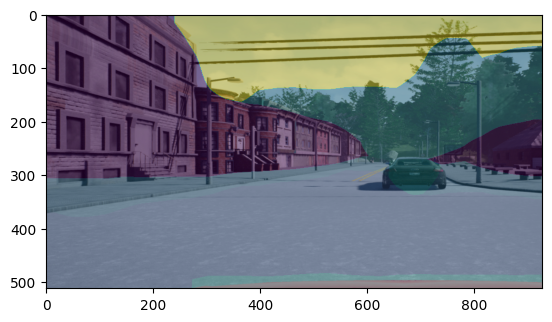

In [18]:
import matplotlib.pyplot as plt
plt.imshow(unNormalize(images[0].cpu()).permute(1,2,0))
plt.imshow(prediction.cpu().numpy(), alpha = 0.4)

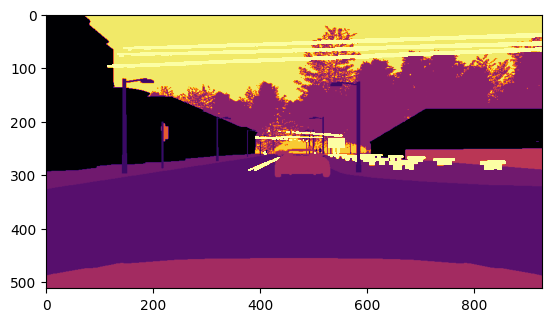

In [21]:
import matplotlib as mpl

plt.imshow(labels[0].cpu().numpy(), cmap = mpl.colormaps['inferno'], vmin = 0, vmax = 16)